In [20]:
#Standard Imports
import os
import sys
import pandas as pd 
import numpy as np
import json
import fiona
import sys
import getpass
import requests
user = getpass.getuser()
sys.dont_write_bytecode = True

sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

from utils_io import *

In [22]:
#Geo imports
import geopandas as gp
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection

In [23]:
#Plot Imports
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [3]:
pass_txt = '../../../passwords/arcgis_enterprise_pass.txt'
password = get_file_contents(pass_txt)

agol_pass_txt = '../../../passwords/agol_pass.txt'
agol_password = get_file_contents(agol_pass_txt)

In [5]:
#Connect to enterprise portal
gis = GIS("https://arcgis.ad.mtc.ca.gov/portal/", "jcroff", password)

In [6]:
#Connect to arcgis online
agol_gis = GIS('https://mtc.maps.arcgis.com/home/','content_MTC',agol_password)

# RHNA Site Selection Pre-Screening Dataset Processing <a name="top"></a>

## Approach

Develop a parcel-level dataset containing factors required by HCD as well as optional factors such as whether the site is located within a high opportunity area, or a transportation priority area, any floor area ratio requirements of the site, etc. The dataset will be developed from a combination of publically available datasets as well as datasets developed by MTC/ABAG from local governments and counties throughout the Bay Area.

## Data Sources

**[Data Sources Inventory](https://mtcdrive.app.box.com/file/700718735166)**

## Table of Contents

1. [Pre-Processing Step](#preprocessing)
2. [Step 4: Process opportunity datasets](#opportunity)
    1. [Process TCAC/HCD Resource Opportunity Areas 2020](#roa)
    2. [Process HUD Fair Market Rents](#fmr)
3. [Step 5: Process accessibility datasets](#accessibility)
    1. [Process Transit Rich Areas](#tra)
    2. [Process Travel Model I VMT](#vmt)
4. [Step 6: Process environment datasets](#environment)
    1. [Process California Protected Area Database](#cpad)
    2. [Process Fire Severity Risk: State and Local Responsibility Areas](#fsr)
    3. [Process BCDC Sea Level Rise Inundation](#slr)
    4. [Process Brownfield Sites](#brownfield)
5. [Step 7: Process planning datasets](#planning)
    1. [Process Priority Development Areas](#pda)
    2. [Process Prior RHNA Sites](#rhna)
    3. [Process Zoning](#zoning)
    4. [Process General Plan](#generalplan)

## Pre-Processing Step <a name="preprocessing"></a>
- This notebook is intented to support the overlay processing work to create the full housing element site selection dataset. Most of this work will not take place in one session so this pre-processing step is meant to be run before proceeding with steps below.  

In [16]:
#Box working directory path
data_dir = os.path.join('/Users',
                        user,
                        'Box',
                        'DataViz Projects',
                        'Data Analysis and Visualization',
                        'Housing Element Site Mapping and Pre-screening',
                        'data')

In [8]:
#Socrata housing site selection db 4x4
housing_site_db_id = 'd8wd-vg4y'

In [9]:
#Pull housing site selection parcels from Socrata
parcels_geojson = pull_geojson_from_socrata(housing_site_db_id)

pulling 2142677 rows as geojson


In [110]:
# Convert to geojson to geodataframe
parcel_columns = ['parcel_id',
                  'geom_id',
                  'county',
                  'city',
                  'apn',
                  'acres',
                  'tract_geoi',
                  'blkgp_geoi',
                  'centroid_x',
                  'centroid_y',
                  'geometry']

parcels = gp.GeoDataFrame.from_features(parcels_geojson['features'],
                                        columns=parcel_columns,
                                        crs='epsg:4326')

In [113]:
#Convert centroid columns to float data type
parcels['centroid_x'] = parcels['centroid_x'].astype(float)
parcels['centroid_y'] = parcels['centroid_y'].astype(float)

In [115]:
#Subset for parcel centroid
columns = ['parcel_id',
          'geom_id',
          'county',
          'city',
          'apn',
          'acres',
          'tract_geoi',
          'blkgp_geoi',
          'centroid_x',
          'centroid_y']
parcels_centroid = parcels[columns]

In [116]:
#Create parcel centroid geodataframe
parcels_centroid = gp.GeoDataFrame(parcels_centroid,
                                  geometry=gp.points_from_xy(parcels.centroid_x,
                                                             parcels.centroid_y),
                                   crs='epsg:4326')

parcels_centroid.head(5)

,parcel_id,geom_id,county,city,apn,acres,tract_geoi,blkgp_geoi,centroid_x,centroid_y,geometry
0,CC216362001,7009279288522476710,13.0,Danville,216362001,0.292997041010582,06013346203,060133462031,-121.980750,37.817481,POINT (-121.98075 37.81748)
1,AL412001710300,N6256491958109459820,1.0,Unincorporated Alameda,412001710300,0.11233469068488,06001435800,060014358004,-122.133371,37.682392,POINT (-122.13337 37.68239)
2,MA07310130,N6871088271220904570,41.0,Ross,07310130,0.164000229689994,06041118100,060411181002,-122.560350,37.967028,POINT (-122.56035 37.96703)
3,SM051152170,298947041927966577,81.0,Unincorporated San Mateo,051152170,0.323938867215386,06081609603,060816096033,-122.260126,37.480667,POINT (-122.26013 37.48067)
4,SN090030001000,N341579833062238894,97.0,Unincorporated Sonoma,090030001000,38.5110827514146,06097154000,060971540001,-122.958405,38.669488,POINT (-122.95841 38.66949)


**[Back to Top](#top)**

## Step 4: Process opportunity datasets <a name="opportunity"></a>

#### TCAC/HCD Resource Opportunity Areas 2020

- TCAC/HCD Resource Opportunity Area data was last updated in early 2020. 
- TCAC/HCD Resource Opportunity Area dataset contains data for the entire Bay Area by census tract and block group. 
- Columns from this dataset that will be associated with parcels include:
    - Final Category
    
- To associate these data with parcels, we will use a two-step join operation. 
    - 1st join: join tract-level data to parcels using the tract geoid added to the framework dataset in earlier steps. This will be an 'inner' join as we only care about the matching records. 
    - 2nd join: join block group-level data to parcels using the block geoid added to the framework dataset in earlier steps. This will be an 'inner' join as we again only care about matching records. 
    - Blocks and Tracts were added to the framework dataset using a point in polygon method. 
    - Urban Areas provide data at the tract level while rural area data were provided at the block group level.

#### HUD Fair Market Rents

- Fair Market Rents (FMRs) data was last updated in 2019.
- Fair Market Rents (FMRs) are used to determine payment standard amounts for the Housing Choice Voucher program, to determine initial renewal rents for some expiring project-based Section 8 contracts, to determine initial rents for housing assistance payment (HAP) contracts in the Moderate Rehabilitation Single Room Occupancy program (Mod Rehab), rent ceilings for rental units in both the HOME Investment Partnerships program and the Emergency Solution Grants program, calculation of maximum award amounts for Continuum of Care recipients and the maximum amount of rent a recipient may pay for property leased with Continuum of Care funds, and calculation of flat rents in Public Housing units. 
- The U.S. Department of Housing and Urban Development (HUD) annually estimates FMRs for Office of Management and Budget (OMB) defined metropolitan areas, some HUD defined subdivisions of OMB metropolitan areas and each nonmetropolitan county. 42 USC 1437f requires FMRs be posted at least 30 days before they are effective and that they are effective at the start of the federal fiscal year (generally October 1).

- Columns from this dataset that will be associated with parcels include: 
    - 0 Bedroom Fair Market Rent
    - 1 Bedroom Fair Market Rent
    - 2 Bedroom Fair Market Rent
    - 3 Bedroom Fair Market Rent
    - 4 Bedroom Fair Market Rent
    - 4 Plus Bedroom Fair Market Rent

**[Back to Top](#top)**
### Process TCAC/HCD Resource Opportunity Areas 2020 <a name="roa"></a>

In [24]:
data_dir

'/Users/jcroff/Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data'

In [125]:
#Read in 2020 TCAC/HCD Resource Opportunity Areas

resource_areas = pd.read_excel(os.path.join(data_dir,'tabular/ctcac_hcd_final_2020_public.xlsx'),
                              dtype={'Census Tract':str,
                                     'Census Block Group':str})

In [126]:
resource_areas['Final Category'].unique()

array(['High Resource', 'Highest Resource',
       'Moderate Resource (Rapidly Changing)', 'Moderate Resource',
       'Low Resource', 'High Segregation & Poverty', nan], dtype=object)

In [22]:
#Inspect resource areas
resource_areas.head(5)

,Census Tract,Census Block Group,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,Final Category
0,06001400100,NaN,Alameda,6001.0,Bay Area Region,0.826,0.406,0.736,0.433,High Resource
1,06001400200,NaN,Alameda,6001.0,Bay Area Region,0.935,0.754,0.794,0.683,Highest Resource
2,06001400300,NaN,Alameda,6001.0,Bay Area Region,0.911,0.741,0.340,0.235,High Resource
3,06001400400,NaN,Alameda,6001.0,Bay Area Region,0.877,0.747,0.429,0.289,High Resource
4,06001400500,NaN,Alameda,6001.0,Bay Area Region,0.802,0.865,0.586,0.397,High Resource


In [23]:
#Return info about resource areas
resource_areas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10144 entries, 0 to 10143
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Census Tract                            10144 non-null  object 
 1   Census Block Group                      3093 non-null   object 
 2   County                                  10144 non-null  object 
 3   County ID                               10143 non-null  float64
 4   Region                                  10144 non-null  object 
 5   Economic Domain Score (by region)       9635 non-null   float64
 6   Environmental Domain Score (by region)  9635 non-null   float64
 7   Education Domain Score (by region)      9635 non-null   float64
 8   Composite Index Score                   8786 non-null   float64
 9   Final Category                          9635 non-null   object 
dtypes: float64(5), object(5)
memory usage: 792.6+ KB


In [24]:
resource_areas[resource_areas['Region'] == 'Bay Area Region'].shape

(1513, 10)

In [25]:
resource_areas['Final Category'].unique()

array(['High Resource', 'Highest Resource',
       'Moderate Resource (Rapidly Changing)', 'Moderate Resource',
       'Low Resource', 'High Segregation & Poverty', nan], dtype=object)

In [26]:
resource_areas['Region'].unique()

array(['Bay Area Region', 'Capital Region', 'Central Valley Region',
       'Inland Empire Region', 'Los Angeles Region',
       'Central Coast Region', 'Orange County Region', 'San Diego Region',
       'Rural Areas'], dtype=object)

In [27]:
#rename columns
resource_areas.rename(columns={'Census Tract':'tract_geoi',
                               'Census Block Group':'blkgp_geoi',
                               'Final Category':'reso_level'},inplace=True)

In [28]:
#subset resource areas at the tract level geography
ra_tracts = resource_areas[(resource_areas['tract_geoi'].notnull()) & 
                           (resource_areas['Region'] == 'Bay Area Region')]

In [29]:
ra_tracts.head(5)

,tract_geoi,blkgp_geoi,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,reso_level
0,06001400100,NaN,Alameda,6001.0,Bay Area Region,0.826,0.406,0.736,0.433,High Resource
1,06001400200,NaN,Alameda,6001.0,Bay Area Region,0.935,0.754,0.794,0.683,Highest Resource
2,06001400300,NaN,Alameda,6001.0,Bay Area Region,0.911,0.741,0.340,0.235,High Resource
3,06001400400,NaN,Alameda,6001.0,Bay Area Region,0.877,0.747,0.429,0.289,High Resource
4,06001400500,NaN,Alameda,6001.0,Bay Area Region,0.802,0.865,0.586,0.397,High Resource


In [31]:
ra_parcel_tracts = pd.merge(parcels[['parcel_id','tract_geoi']],
                            ra_tracts[['tract_geoi','reso_level']], 
                            on='tract_geoi',
                            how='inner')

In [32]:
ra_parcel_tracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1982500 entries, 0 to 1982499
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   parcel_id   object
 1   tract_geoi  object
 2   reso_level  object
dtypes: object(3)
memory usage: 60.5+ MB


In [33]:
parcels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2142677 entries, 0 to 2142676
Data columns (total 11 columns):
 #   Column      Dtype   
---  ------      -----   
 0   parcel_id   object  
 1   geom_id     object  
 2   county      object  
 3   city        object  
 4   apn         object  
 5   acres       object  
 6   tract_geoi  object  
 7   blkgp_geoi  object  
 8   centroid_x  float64 
 9   centroid_y  float64 
 10  geometry    geometry
dtypes: float64(2), geometry(1), object(8)
memory usage: 179.8+ MB


In [34]:
ra_parcel_tracts.head(10)

,parcel_id,tract_geoi,reso_level
0,AL99A256000110,06001451101,Low Resource
1,AL99A256000109,06001451101,Low Resource
2,AL99A293100100,06001451101,Low Resource
3,AL99A256000106,06001451101,Low Resource
4,AL99A248000103,06001451101,Low Resource
5,AL99B812005500,06001451101,Low Resource
6,AL99A261000102,06001451101,Low Resource
7,AL99A263001102,06001451101,Low Resource
8,AL99A190000701,06001451101,Low Resource
9,AL99B540605500,06001451101,Low Resource


In [35]:
#subset rural area block groups
ra_blkgp = resource_areas[(resource_areas['blkgp_geoi'].notnull()) & 
                           (resource_areas['Region'] == 'Rural Areas')]

In [36]:
ra_blkgp.head(5)

,tract_geoi,blkgp_geoi,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,reso_level
7051,06003010000,060030100001,Alpine,6003.0,Rural Areas,NaN,NaN,NaN,NaN,NaN
7052,06003010000,060030100002,Alpine,6003.0,Rural Areas,NaN,NaN,NaN,NaN,NaN
7053,06005000101,060050001011,Amador,6005.0,Rural Areas,0.192,0.885,0.115,-0.163,Moderate Resource
7054,06005000101,060050001012,Amador,6005.0,Rural Areas,0.115,0.885,0.115,-0.170,Low Resource
7055,06005000101,060050001013,Amador,6005.0,Rural Areas,0.077,0.885,0.115,-0.271,Low Resource


In [37]:
#Join to parcels
ra_parcel_blkgp = pd.merge(parcels[['parcel_id','blkgp_geoi']],
                          ra_blkgp[['blkgp_geoi','reso_level']],
                          on='blkgp_geoi',
                          how='inner')

In [38]:
ra_parcel_blkgp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158444 entries, 0 to 158443
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   parcel_id   158444 non-null  object
 1   blkgp_geoi  158444 non-null  object
 2   reso_level  156404 non-null  object
dtypes: object(3)
memory usage: 4.8+ MB


In [39]:
ra_parcel_blkgp.head(5)

,parcel_id,blkgp_geoi,reso_level
0,SN103160004000,060971543023,High Resource
1,SN103060016000,060971543023,High Resource
2,SN073280070000,060971543023,High Resource
3,SN103060011000,060971543023,High Resource
4,SN073260038000,060971543023,High Resource


In [40]:
ra_parcels_tracts_blkgp = ra_parcel_tracts.append(ra_parcel_blkgp)

In [41]:
ra_parcels_tracts_blkgp.head(10)

,parcel_id,tract_geoi,reso_level,blkgp_geoi
0,AL99A256000110,06001451101,Low Resource,NaN
1,AL99A256000109,06001451101,Low Resource,NaN
2,AL99A293100100,06001451101,Low Resource,NaN
3,AL99A256000106,06001451101,Low Resource,NaN
4,AL99A248000103,06001451101,Low Resource,NaN
5,AL99B812005500,06001451101,Low Resource,NaN
6,AL99A261000102,06001451101,Low Resource,NaN
7,AL99A263001102,06001451101,Low Resource,NaN
8,AL99A190000701,06001451101,Low Resource,NaN
9,AL99B540605500,06001451101,Low Resource,NaN


In [42]:
ra_parcels_tracts_blkgp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140944 entries, 0 to 158443
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   parcel_id   object
 1   tract_geoi  object
 2   reso_level  object
 3   blkgp_geoi  object
dtypes: object(4)
memory usage: 81.7+ MB


In [43]:
ra_parcels_tracts_blkgp[ra_parcels_tracts_blkgp['blkgp_geoi'].notnull()]

,parcel_id,tract_geoi,reso_level,blkgp_geoi
0,SN103160004000,NaN,High Resource,060971543023
1,SN103060016000,NaN,High Resource,060971543023
2,SN073280070000,NaN,High Resource,060971543023
3,SN103060011000,NaN,High Resource,060971543023
4,SN073260038000,NaN,High Resource,060971543023
...,...,...,...,...
158439,SN056252023000,NaN,Moderate Resource,060971503062
158440,SN056151048000,NaN,Moderate Resource,060971503062
158441,SN056151053000,NaN,Moderate Resource,060971503062
158442,SN056336009000,NaN,Moderate Resource,060971503062


In [44]:
#Upsert to socrata
upsert_df_socrata(ra_parcels_tracts_blkgp[['parcel_id','reso_level']],
                  housing_site_db_id,
                  chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to d8wd-vg4y
took 8.7237 minutes


**[Back to Top](#top)**
### Process HUD Fair Market Rents <a name="fmr"></a>

In [26]:
#fmr = pull_geodata_from_argis('7d7628ebd2244afeaf4f8c0d51ddc42b',client=gis)

In [27]:
data_dir

'/Users/jcroff/Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data'

In [72]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk']

In [73]:
fmr = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                  driver='FileGDB',
                  layer='hud_fair_market_rents_bay_area_7_28_20')

In [74]:
fmr.head(10)

,fmr_0bdr,fmr_1bdr,fmr_2bdr,fmr_3bdr,fmr_4bdr,fmr_area,fmr_code,fmr_4plbdr,Shape__Area,Shape__Length,Shape_Length,Shape_Area,geometry
0,1095.0,1289.0,1705.0,2465.0,2685.0,"Napa, CA MSA",METRO34900M34900,2685.0,3.340480e+09,349734.279550,2.788192,0.210944,"MULTIPOLYGON (((-122.35430 38.83715, -122.3499..."
1,983.0,1184.0,1443.0,2086.0,2531.0,"Vallejo-Fairfield, CA MSA",METRO46700M46700,2531.0,3.744063e+09,337353.781359,2.756668,0.237205,"MULTIPOLYGON (((-121.88139 38.53820, -121.8798..."
2,1397.0,1693.0,2109.0,2902.0,3558.0,"Oakland-Fremont, CA HUD Metro FMR Area",METRO41860MM5775,3558.0,6.241888e+09,621020.566568,5.063336,0.398083,"MULTIPOLYGON (((-121.58225 38.09489, -121.5812..."
3,1822.0,2255.0,2809.0,3663.0,3912.0,"San Francisco, CA HUD Metro FMR Area",METRO41860MM7360,3912.0,4.275324e+09,955407.207799,7.646650,0.272706,"MULTIPOLYGON (((-122.90949 38.31439, -122.9081..."
4,1865.0,2212.0,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458,"MULTIPOLYGON (((-121.86339 37.48462, -121.8007..."
5,1254.0,1447.0,1887.0,2728.0,3298.0,"Santa Rosa, CA MSA",METRO42220M42220,3298.0,6.739300e+09,497301.082655,4.051204,0.425442,"MULTIPOLYGON (((-123.01878 38.85237, -123.0069..."


In [75]:
fmr['fmr_area'].unique()

array(['Napa, CA MSA', 'Vallejo-Fairfield, CA MSA',
       'Oakland-Fremont, CA HUD Metro FMR Area',
       'San Francisco, CA HUD Metro FMR Area',
       'San Jose-Sunnyvale-Santa Clara, CA HUD Metro FMR Area',
       'Santa Rosa, CA MSA'], dtype=object)

In [76]:
fmr[fmr['fmr_code'] == 'METRO41860MM7360']

,fmr_0bdr,fmr_1bdr,fmr_2bdr,fmr_3bdr,fmr_4bdr,fmr_area,fmr_code,fmr_4plbdr,Shape__Area,Shape__Length,Shape_Length,Shape_Area,geometry
3,1822.0,2255.0,2809.0,3663.0,3912.0,"San Francisco, CA HUD Metro FMR Area",METRO41860MM7360,3912.0,4.275324e+09,955407.207799,7.64665,0.272706,"MULTIPOLYGON (((-122.90949 38.31439, -122.9081..."


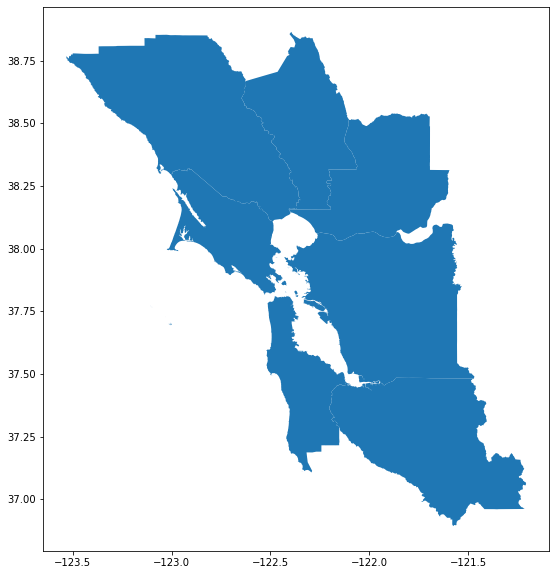

In [77]:
fmr.plot(figsize=(10,10));

In [78]:
parcels_centroid.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [79]:
fmr.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [80]:
fmr_parcels_centroid = gp.sjoin(parcels_centroid,
                               fmr,
                               how='left',
                               op='intersects')

In [81]:
fmr_parcels_centroid.head(5)

,parcel_id,geom_id,county,city,apn,acres,tract_geoi,blkgp_geoi,centroid_x,centroid_y,...,fmr_2bdr,fmr_3bdr,fmr_4bdr,fmr_area,fmr_code,fmr_4plbdr,Shape__Area,Shape__Length,Shape_Length,Shape_Area
0,AL99A256000110,N5817775096018233128,1.0,Unincorporated Alameda,99A256000110,106.927944937336,06001451101,060014511013,-121.596790,37.581694,...,2109.0,2902.0,3558.0,"Oakland-Fremont, CA HUD Metro FMR Area",METRO41860MM5775,3558.0,6.241888e+09,621020.566568,5.063336,0.398083
1,AL525128205800,7316709377530651714,1.0,Fremont,525128205800,0.370856727459726,06001443002,060014430023,-121.957118,37.521598,...,2109.0,2902.0,3558.0,"Oakland-Fremont, CA HUD Metro FMR Area",METRO41860MM5775,3558.0,6.241888e+09,621020.566568,5.063336,0.398083
2,AL99A256000109,N527005802064910811,1.0,Unincorporated Alameda,99A256000109,101.938704741621,06001451101,060014511013,-121.603007,37.581767,...,2109.0,2902.0,3558.0,"Oakland-Fremont, CA HUD Metro FMR Area",METRO41860MM5775,3558.0,6.241888e+09,621020.566568,5.063336,0.398083
3,AL986001300100,3727940690343027220,1.0,Dublin,986001300100,1.27190710767633,06001450102,060014501023,-121.881581,37.709281,...,2109.0,2902.0,3558.0,"Oakland-Fremont, CA HUD Metro FMR Area",METRO41860MM5775,3558.0,6.241888e+09,621020.566568,5.063336,0.398083
4,AL99A293200300,2796948223684118431,1.0,Unincorporated Alameda,99A293200300,2.10466188922604,06001451501,060014515012,-121.729299,37.669970,...,2109.0,2902.0,3558.0,"Oakland-Fremont, CA HUD Metro FMR Area",METRO41860MM5775,3558.0,6.241888e+09,621020.566568,5.063336,0.398083


In [82]:
fmr_parcels_centroid[fmr_parcels_centroid['fmr_code'].isnull()].shape

(2574, 24)

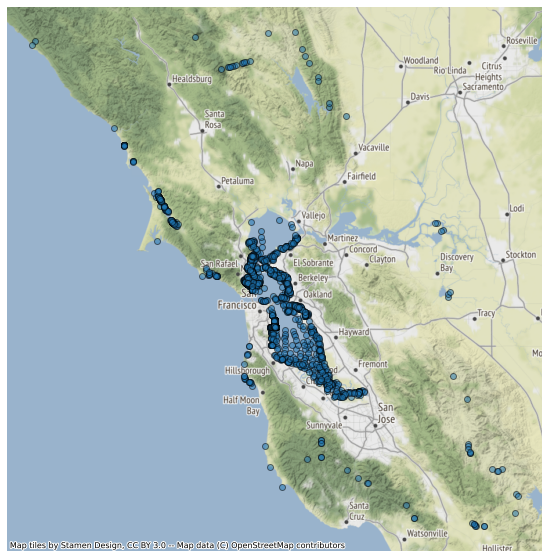

In [83]:
fmr_null_parcels = fmr_parcels_centroid[fmr_parcels_centroid['index_right'].isnull()].to_crs('epsg:3857')
ax = fmr_null_parcels.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ax.set_axis_off()
ctx.add_basemap(ax);

In [84]:
#upsert to socrata
sub_columns = ['parcel_id',
               'fmr_0bdr', 
               'fmr_1bdr', 
               'fmr_2bdr', 
               'fmr_3bdr',
               'fmr_4bdr',
               'fmr_4plbdr']
upsert_df_socrata(fmr_parcels_centroid[sub_columns],
                  housing_site_db_id,
                  chunksize=50000)

upserting data to Socrata in 43 chunks of 50000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
upserted chunk 22
upserted chunk 23
upserted chunk 24
upserted chunk 25
upserted chunk 26
upserted chunk 27
upserted chunk 28
upserted chunk 29
upserted chunk 30
upserted chunk 31
upserted chunk 32
upserted chunk 33
upserted chunk 34
upserted chunk 35
upserted chunk 36
upserted chunk 37
upserted chunk 38
upserted chunk 39
upserted chunk 40
upserted chunk 41
upserted chunk 42
data upserted to d8wd-vg4y
took 11.1095 minutes


**[Back to Top](#top)**

## Step 5: Process accessibility datasets <a name="accessibility"></a>

#### MTC/ABAG Transit Rich Areas 2020 (TRAs)

- Transit rich areas will be assigned to parcels using a point (representative centroid) in polygon (Transit Rich Area) method. This is a simple boolean flagging (0: Outside TRA, 1: Inside TRA) 

A Transit-Rich Area is defined as areas 1/2 mile of:
- An existing, under construction, or fully funded rail station or ferry terminal
- A rail station or ferry terminal included in the PBA 2050 Final Blueprint
- A bus stop with headways of 15 minutes or less during the AM (6:00 - 10:00 AM) and PM (3:00 - 7:00 PM) peak periods in January 2020

#### Travel Model I Vehicle Miles Traveled (VMT)

**[Back to Top](#top)**
### Process Transit Rich Areas <a name="tra"></a>

In [101]:
# tra_2020 = pull_geodata_from_argis('81a628f55b3d458095c9770331aca5a4',client=gis) 
# tra_2020

In [102]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk']

In [103]:
#Read fire severity risk data from project fgdb
tra_2020 = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                  driver='FileGDB',
                  layer='transit_rich_areas_2020')

In [104]:
tra_2020.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [105]:
#rename dissolve column to tra
tra_2020.rename(columns={'diss':'tra'},
                inplace=True)

In [106]:
#Check CRS
print(parcels_centroid.crs)
print(tra_2020.crs)

epsg:4326
epsg:4326


In [107]:
#Spatially join parcel centroids and tras
tra_parcel_centroid = gp.sjoin(parcels_centroid,
                              tra_2020,
                              how='left',
                              op='intersects')

In [108]:
tra_parcel_centroid.head(5)

,parcel_id,geom_id,county,city,apn,acres,tract_geoi,blkgp_geoi,centroid_x,centroid_y,geometry,index_right,tra,f_name,Shape_Length,Shape_Area
0,AL99A256000110,N5817775096018233128,1.0,Unincorporated Alameda,99A256000110,106.927944937336,06001451101,060014511013,-121.596790,37.581694,POINT (-121.59679 37.58169),NaN,NaN,NaN,NaN,NaN
1,AL525128205800,7316709377530651714,1.0,Fremont,525128205800,0.370856727459726,06001443002,060014430023,-121.957118,37.521598,POINT (-121.95712 37.52160),NaN,NaN,NaN,NaN,NaN
2,AL99A256000109,N527005802064910811,1.0,Unincorporated Alameda,99A256000109,101.938704741621,06001451101,060014511013,-121.603007,37.581767,POINT (-121.60301 37.58177),NaN,NaN,NaN,NaN,NaN
3,AL986001300100,3727940690343027220,1.0,Dublin,986001300100,1.27190710767633,06001450102,060014501023,-121.881581,37.709281,POINT (-121.88158 37.70928),0.0,1.0,Transit Rich Areas,12.296486,0.122582
4,AL99A293200300,2796948223684118431,1.0,Unincorporated Alameda,99A293200300,2.10466188922604,06001451501,060014515012,-121.729299,37.669970,POINT (-121.72930 37.66997),NaN,NaN,NaN,NaN,NaN


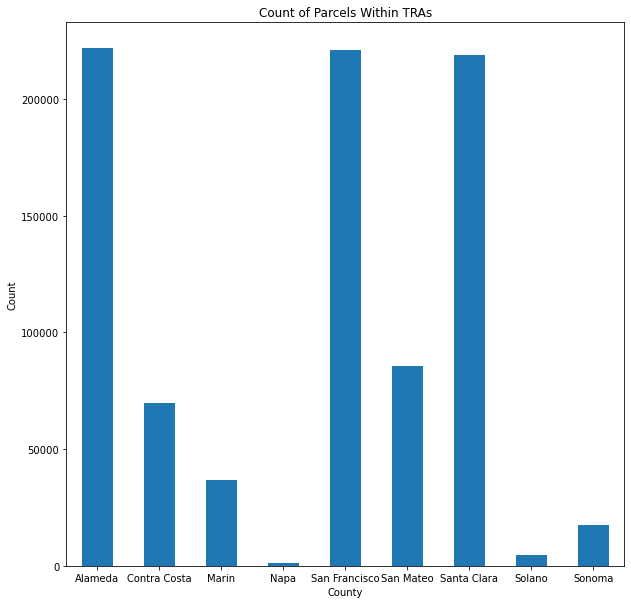

In [109]:
#Graph major stop parcels by county
parcels_tra_ct = tra_parcel_centroid[tra_parcel_centroid['tra'].notnull()].groupby(['county']).agg('size')

#plot
parcels_tra_ct.plot(kind='bar',figsize=(10,10))

#title and labels
plt.title('Count of Parcels Within TRAs')
plt.xlabel('County')
plt.ylabel('Count')

plt.xticks( 
    [0,1,2,3,4,5,6,7,8], # positions
    ['Alameda','Contra Costa','Marin','Napa','San Francisco','San Mateo','Santa Clara','Solano','Sonoma'], # labels
    rotation = 0 # default is 90
)

# convert to non-scientific notation 
plt.ticklabel_format(axis = 'y', style='plain');

In [117]:
#subset SF to view
parcels_tra_al = tra_parcel_centroid[(tra_parcel_centroid['tra'] == 1) & 
                                               (tra_parcel_centroid['county'] == '1.0')]

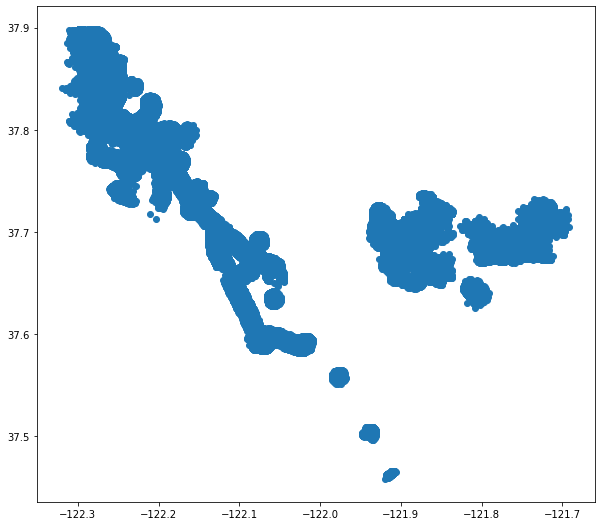

In [118]:
parcels_tra_al.plot(figsize=(10,10));

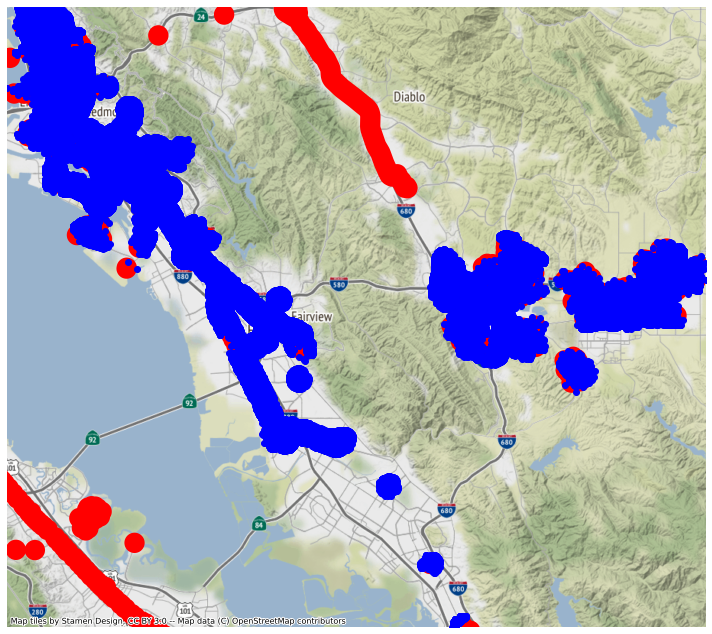

In [119]:
fig, ax = plt.subplots(figsize=(10,10))

tra_2020.to_crs('epsg:3857').plot(color='red',ax=ax)

parcels_tra_al.to_crs('epsg:3857').plot(color='blue',ax=ax)

# Crop map to sf bounds
minx, miny, maxx, maxy = parcels_tra_al.to_crs('epsg:3857').geometry.total_bounds

ax.set_xlim(minx,maxx)
ax.set_ylim(miny,maxy)
ax.set_axis_off()
ctx.add_basemap(ax)

#Display map
plt.tight_layout()
plt.show()

In [120]:
#Fill tpa flag column NaN values
tra_parcel_centroid['tra'].fillna(0,inplace=True)

In [121]:
tra_parcel_centroid.head(10)

,parcel_id,geom_id,county,city,apn,acres,tract_geoi,blkgp_geoi,centroid_x,centroid_y,geometry,index_right,tra,f_name,Shape_Length,Shape_Area
0,AL99A256000110,N5817775096018233128,1.0,Unincorporated Alameda,99A256000110,106.927944937336,06001451101,060014511013,-121.596790,37.581694,POINT (-121.59679 37.58169),NaN,0.0,NaN,NaN,NaN
1,AL525128205800,7316709377530651714,1.0,Fremont,525128205800,0.370856727459726,06001443002,060014430023,-121.957118,37.521598,POINT (-121.95712 37.52160),NaN,0.0,NaN,NaN,NaN
2,AL99A256000109,N527005802064910811,1.0,Unincorporated Alameda,99A256000109,101.938704741621,06001451101,060014511013,-121.603007,37.581767,POINT (-121.60301 37.58177),NaN,0.0,NaN,NaN,NaN
3,AL986001300100,3727940690343027220,1.0,Dublin,986001300100,1.27190710767633,06001450102,060014501023,-121.881581,37.709281,POINT (-121.88158 37.70928),0.0,1.0,Transit Rich Areas,12.296486,0.122582
4,AL99A293200300,2796948223684118431,1.0,Unincorporated Alameda,99A293200300,2.10466188922604,06001451501,060014515012,-121.729299,37.669970,POINT (-121.72930 37.66997),NaN,0.0,NaN,NaN,NaN
5,AL074135111300,3889316997659474464,1.0,Alameda,074135111300,0.999323862357131,06001427300,060014273002,-122.274266,37.781597,POINT (-122.27427 37.78160),0.0,1.0,Transit Rich Areas,12.296486,0.122582
6,MULT_GEOM_AL543044324300_6789254083167282635,6789254083167282635,1.0,Fremont,543044324300,0.354355392380687,06001441523,060014415231,-122.049176,37.564353,POINT (-122.04918 37.56435),NaN,0.0,NaN,NaN,NaN
7,AL543042806300,N4262495264119460416,1.0,Fremont,543042806300,1.52529970991809,06001441401,060014414014,-122.033590,37.570074,POINT (-122.03359 37.57007),NaN,0.0,NaN,NaN,NaN
8,MULT_GEOM_AL519124607600_801833792779021835,801833792779021835,1.0,Fremont,519124607600,2.28906493569677,06001443321,060014433212,-121.923030,37.489675,POINT (-121.92303 37.48967),NaN,0.0,NaN,NaN,NaN
9,MULT_GEOM_AL048641100100_N6006328884037005710,N6006328884037005710,1.0,Oakland,048641100100,2.66689980932023,06001410000,060014100003,-122.138762,37.755556,POINT (-122.13876 37.75556),NaN,0.0,NaN,NaN,NaN


In [122]:
#Upsert to socrata
upsert_df_socrata(tra_parcel_centroid[['parcel_id','tra']],
                  housing_site_db_id,
                  chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to d8wd-vg4y
took 9.2299 minutes


**[Back to Top](#top)**
### Process Travel Model I VMT <a name="vmt"></a>

**[Back to Top](#top)**

## Step 6: Process environment datasets <a name="environment"></a>

#### California Protected Area Database
- California Protected Areas (CPAD) will be assigned to parcels using a simple point in polygon spatial join method. Parcel centroids that intersect CPAD areas will be flagged (0: Outside CPAD Area, 1: Inside CPAD Area) 

#### Fire Severity Risk: State and Local Responsibility Areas

Fire Severity Risk in State and Local Responsibility Areas for the San Francisco Bay Region. Data downloaded from the California Department of Forestry and Fire Protection.

This data set represents Moderate, High, and Very High Fire Hazard Severity Zones in State Responsibility Areas (SRA) and Very High Fire Hazard Severity Zones in Local Responsibility Areas (LRA) for the San Francisco Bay Region and surrounding counties. The data was assembled by the Metropolitan Transportation Commission from multiple shapefiles provided by the California Department of Forestry and Fire Protection (CAL FIRE). The SRA data was extracted from a statewide shapefile and the LRA data is a combination of county shapefiles.

- Columns from this dataset that will be associated with parcels include:
    - Fire Risk Severity 
    - Fire Responsibility Areas

- Fire risk severity will be assigned to parcels using a point in polygon spatial join method. 
- Fire severity classifications will be added to any parcel centroid that intersections the fire severity polygon.

#### BCDC Sea Level Rise Inundation

**[Back to Top](#top)**
### Process California Protected Area Database data <a name="cpad"></a>

In [48]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk',
 'california_protected_areas_database',
 'regional_housing_need_assessment_sites',
 'art_slr_inundation_poly_77',
 'art_slr_lowlying_poly_77',
 'california_protected_areas_datbase_bay_area']

In [50]:
#Read fire severity risk data from project fgdb
cpad = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                  driver='FileGDB',
                  layer='california_protected_areas_datbase_bay_area')

In [51]:
cpad.head(5)

,access_typ,park_name,park_url,suid_nma,mng_ag_id,mng_agency,mng_ag_lev,mng_ag_typ,agncy_web,layer,acres,label_name,yr_est,shape_Length,shape_Area,geometry
0,Open Access,Modini Mayacamas Preserves,http://egret.org/visit_modini_mayacamas,383,3005,Audubon Canyon Ranch,Non Profit,Non Profit - Conservation,http://www.egret.org,Non Governmental Organization,1279.161,Modini Mayacamas Preserves,0,0.129172,0.000536,"MULTIPOLYGON (((-122.76950 38.74085, -122.7657..."
1,Open Access,Vintage Meadows Park,,33477,1059,"Cloverdale, City of",City,City Agency,http://www.cloverdale.net/index.aspx?nid=152,City,3.513,Vintage Meadows Park,0,0.004803,0.000001,"MULTIPOLYGON (((-123.02368 38.79883, -123.0244..."
2,Open Access,Water Dog Lake Canyon,http://www.belmont.gov/Home/Components/Facilit...,534,1025,"Belmont, City of",City,City Agency,http://www.belmont.gov/city-hall/park-and-recr...,City,276.470,Water Dog Lake Canyon,1975,0.112598,0.000114,"MULTIPOLYGON (((-122.30523 37.51002, -122.3053..."
3,Open Access,McKegney Green,,31739,1348,"Tiburon, Town of",City,City Agency,http://www.ci.tiburon.ca.us/,City,11.486,McKegney Green,0,0.017734,0.000005,"MULTIPOLYGON (((-122.48771 37.89490, -122.4863..."
4,Open Access,Richardson Bay Lineal Park,,31740,1348,"Tiburon, Town of",City,City Agency,http://www.ci.tiburon.ca.us/,City,11.346,Richardson Bay Lineal Park,0,0.053122,0.000005,"MULTIPOLYGON (((-122.46377 37.87877, -122.4635..."


In [52]:
parcels_centroid.head(5)

,parcel_id,geom_id,county,city,apn,acres,tract_geoi,blkgp_geoi,centroid_x,centroid_y,geometry
0,CC179131016,N812175068441799346,13.0,Walnut Creek,179131016,0.571898281089132,06013343002,060133430021,-122.047866,37.905228,POINT (-122.04787 37.90523)
1,CC216362001,7009279288522476710,13.0,Danville,216362001,0.292997041010582,06013346203,060133462031,-121.980750,37.817481,POINT (-121.98075 37.81748)
2,CC093490066,N4056657309732995167,13.0,Pittsburg,093490066,0.0674453215949994,06013355200,060133552002,-121.953865,38.016272,POINT (-121.95386 38.01627)
3,AL412001710300,N6256491958109459820,1.0,Unincorporated Alameda,412001710300,0.11233469068488,06001435800,060014358004,-122.133371,37.682392,POINT (-122.13337 37.68239)
4,MA07310130,N6871088271220904570,41.0,Ross,07310130,0.164000229689994,06041118100,060411181002,-122.560350,37.967028,POINT (-122.56035 37.96703)


In [53]:
cpad.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
#Spatially join parcel centroids with CPAD
cpad_parcels_centroid = gp.sjoin(parcels_centroid,
                                 cpad,
                                how='left',
                                op='intersects')

In [55]:
cpad_parcels_centroid.shape

(2142681, 27)

In [56]:
cpad_parcels_centroid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2142681 entries, 0 to 2142676
Data columns (total 27 columns):
 #   Column        Dtype   
---  ------        -----   
 0   parcel_id     object  
 1   geom_id       object  
 2   county        object  
 3   city          object  
 4   apn           object  
 5   acres_left    object  
 6   tract_geoi    object  
 7   blkgp_geoi    object  
 8   centroid_x    float64 
 9   centroid_y    float64 
 10  geometry      geometry
 11  index_right   float64 
 12  access_typ    object  
 13  park_name     object  
 14  park_url      object  
 15  suid_nma      float64 
 16  mng_ag_id     float64 
 17  mng_agency    object  
 18  mng_ag_lev    object  
 19  mng_ag_typ    object  
 20  agncy_web     object  
 21  layer         object  
 22  acres_right   float64 
 23  label_name    object  
 24  yr_est        float64 
 25  shape_Length  float64 
 26  shape_Area    float64 
dtypes: float64(9), geometry(1), object(17)
memory usage: 457.7+ MB

In [57]:
cpad_parcels_centroid.head(5)

,parcel_id,geom_id,county,city,apn,acres_left,tract_geoi,blkgp_geoi,centroid_x,centroid_y,...,mng_agency,mng_ag_lev,mng_ag_typ,agncy_web,layer,acres_right,label_name,yr_est,shape_Length,shape_Area
0,CC179131016,N812175068441799346,13.0,Walnut Creek,179131016,0.571898281089132,06013343002,060133430021,-122.047866,37.905228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CC216362001,7009279288522476710,13.0,Danville,216362001,0.292997041010582,06013346203,060133462031,-121.980750,37.817481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CC093490066,N4056657309732995167,13.0,Pittsburg,093490066,0.0674453215949994,06013355200,060133552002,-121.953865,38.016272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL412001710300,N6256491958109459820,1.0,Unincorporated Alameda,412001710300,0.11233469068488,06001435800,060014358004,-122.133371,37.682392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MA07310130,N6871088271220904570,41.0,Ross,07310130,0.164000229689994,06041118100,060411181002,-122.560350,37.967028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
cpad_parcels_centroid[cpad_parcels_centroid['index_right'].notnull()].shape

(17344, 27)

In [59]:
#Add cpad flag column
cpad_parcels_centroid['cpad'] = np.where(cpad_parcels_centroid['index_right'].notnull(),1,0)

In [61]:
#Review number of parcels flagged as park by county
cpad_parcels_centroid[cpad_parcels_centroid['cpad'] ==1].groupby(['cpad','county'])[['cpad','county']].sum()

cpad
cpad county      
1    1.0     2742
     13.0    2365
     41.0    2264
     55.0     920
     75.0     967
     81.0    2259
     85.0    2880
     95.0    1113
     97.0    1834

In [64]:
cpad_parcels_centroid[['parcel_id','cpad']].head(5)

,parcel_id,cpad
0,CC179131016,0
1,CC216362001,0
2,CC093490066,0
3,AL412001710300,0
4,MA07310130,0


In [65]:
#Upsert to socrata
upsert_df_socrata(cpad_parcels_centroid[['parcel_id','cpad']],
                  housing_site_db_id,
                  chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to d8wd-vg4y
took 10.0797 minutes


**[Back to Top](#top)**
### Process Fire Severity Risk data <a name="fsr"></a>

In [28]:
data_dir

'/Users/jcroff/Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data'

In [125]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk']

In [123]:
#Read fire severity risk data from project fgdb
fsr = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                  driver='FileGDB',
                  layer='cdf_fire_responsibility_areas_and_risk')

In [124]:
fsr['haz_class'].unique()

array(['Very High', 'Moderate', 'High'], dtype=object)

In [127]:
fsr.head(5)

,fipco,incorp,fra,haz_code,haz_class,Shape__Area,Shape__Length,Shape_Length,Shape_Area,geometry
0,CA001,,LRA,3,Very High,0.000106,0.086169,0.086169,0.000106,"MULTIPOLYGON (((-121.88522 37.59440, -121.8854..."
1,CA001,,LRA,3,Very High,0.000036,0.038931,0.038931,0.000036,"MULTIPOLYGON (((-121.90256 37.63428, -121.9024..."
2,CA001,,LRA,3,Very High,0.000362,0.255788,0.255788,0.000362,"MULTIPOLYGON (((-122.12722 37.71571, -122.1271..."
3,CA001,,LRA,3,Very High,0.000003,0.007693,0.007693,0.000003,"MULTIPOLYGON (((-122.12484 37.72801, -122.1249..."
4,CA001,Y,LRA,3,Very High,0.000067,0.050632,0.050632,0.000067,"MULTIPOLYGON (((-121.88361 37.62573, -121.8834..."


In [128]:
#Rename columns to match final data schema
fsr.rename(columns={'haz_class':'fire_risk',
                    'fra':'fire_autho'},
           inplace=True)

In [129]:
fsr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   fipco          5772 non-null   object  
 1   incorp         5772 non-null   object  
 2   fire_autho     5772 non-null   object  
 3   haz_code       5772 non-null   int64   
 4   fire_risk      5772 non-null   object  
 5   Shape__Area    5772 non-null   float64 
 6   Shape__Length  5772 non-null   float64 
 7   Shape_Length   5772 non-null   float64 
 8   Shape_Area     5772 non-null   float64 
 9   geometry       5772 non-null   geometry
dtypes: float64(4), geometry(1), int64(1), object(4)
memory usage: 451.1+ KB


In [130]:
fsr.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [131]:
#Spatial join parcel centroids to fire risk areas
fsr_parcels_centroid = gp.sjoin(parcels_centroid,
                               fsr,
                               how='inner',
                               op='intersects')

In [132]:
fsr_parcels_centroid.head(5)

,parcel_id,geom_id,county,city,apn,acres,tract_geoi,blkgp_geoi,centroid_x,centroid_y,...,index_right,fipco,incorp,fire_autho,haz_code,fire_risk,Shape__Area,Shape__Length,Shape_Length,Shape_Area
0,AL99A256000110,N5817775096018233128,1.0,Unincorporated Alameda,99A256000110,106.927944937336,06001451101,060014511013,-121.596790,37.581694,...,173,CA001,,SRA,2,High,0.049243,10.015399,10.015399,0.049243
2,AL99A256000109,N527005802064910811,1.0,Unincorporated Alameda,99A256000109,101.938704741621,06001451101,060014511013,-121.603007,37.581767,...,173,CA001,,SRA,2,High,0.049243,10.015399,10.015399,0.049243
76,AL99A256000106,N880204091249587081,1.0,Unincorporated Alameda,99A256000106,443.43311770037,06001451101,060014511013,-121.595256,37.588110,...,173,CA001,,SRA,2,High,0.049243,10.015399,10.015399,0.049243
96,AL99A248000103,N5003171782010529802,1.0,Unincorporated Alameda,99A248000103,149.517267569153,06001451101,060014511013,-121.675262,37.604694,...,173,CA001,,SRA,2,High,0.049243,10.015399,10.015399,0.049243
118,AL99A261000102,5322632474334927637,1.0,Unincorporated Alameda,99A261000102,683.769543128512,06001451101,060014511013,-121.578078,37.541819,...,173,CA001,,SRA,2,High,0.049243,10.015399,10.015399,0.049243


In [133]:
fsr_parcels_centroid.shape

(179714, 21)

In [134]:
fsr_parcels_centroid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 179714 entries, 0 to 2133282
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   parcel_id      179714 non-null  object  
 1   geom_id        179714 non-null  object  
 2   county         179714 non-null  object  
 3   city           179714 non-null  object  
 4   apn            179714 non-null  object  
 5   acres          179714 non-null  object  
 6   tract_geoi     179602 non-null  object  
 7   blkgp_geoi     179602 non-null  object  
 8   centroid_x     179714 non-null  float64 
 9   centroid_y     179714 non-null  float64 
 10  geometry       179714 non-null  geometry
 11  index_right    179714 non-null  int64   
 12  fipco          179714 non-null  object  
 13  incorp         179714 non-null  object  
 14  fire_autho     179714 non-null  object  
 15  haz_code       179714 non-null  int64   
 16  fire_risk      179714 non-null  object  
 17  S

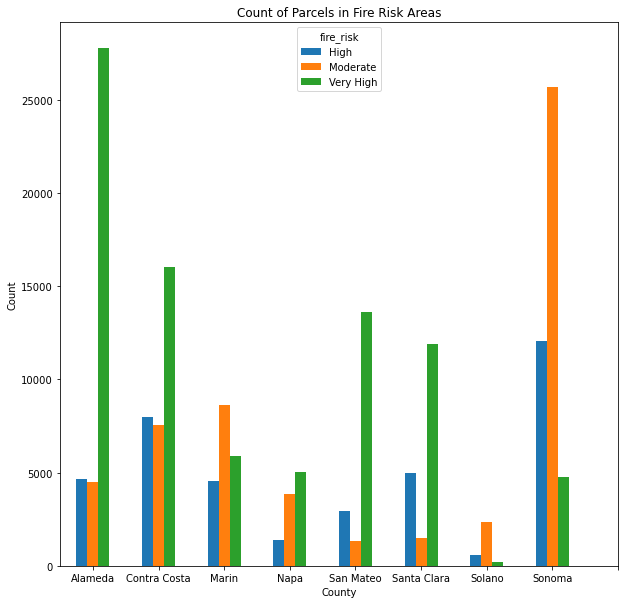

In [136]:
fsr_risk_by_county = fsr_parcels_centroid.groupby(['county','fire_risk'])[['county','fire_risk']].agg('size')

#plot
fsr_risk_by_county.unstack().plot(kind='bar',figsize=(10,10))

#title and labels
plt.title('Count of Parcels in Fire Risk Areas')
plt.xlabel('County')
plt.ylabel('Count')

plt.xticks( 
    [0,1,2,3,4,5,6,7,8], # positions
    ['Alameda','Contra Costa','Marin','Napa','San Mateo','Santa Clara','Solano','Sonoma'], # labels
    rotation = 0 # default is 90
)

# convert to non-scientific notation 
plt.ticklabel_format(axis = 'y', style='plain');

In [137]:
fsr_parcels_centroid[['parcel_id','fire_autho','fire_risk']].head(5)

,parcel_id,fire_autho,fire_risk
0,AL99A256000110,SRA,High
2,AL99A256000109,SRA,High
76,AL99A256000106,SRA,High
96,AL99A248000103,SRA,High
118,AL99A261000102,SRA,High


In [138]:
upsert_df_socrata(fsr_parcels_centroid[['parcel_id','fire_autho','fire_risk']],
                  housing_site_db_id)

upserting data to Socrata in 1 chunks of 179714 rows each
upserted chunk 0
data upserted to d8wd-vg4y
took 58.088 seconds


**[Back to Top](#top)**
### Process BCDC Sea Level Rise Dataset <a name="slr"></a>

In [119]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk',
 'california_protected_areas_database',
 'regional_housing_need_assessment_sites',
 'california_protected_areas_datbase_bay_area',
 'art_slr_lowlying_poly_77',
 'art_slr_inundation_poly_77']

In [120]:
#BCDC Sea Level Rise Data
bcdc = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                  driver='FileGDB',
                  layer='art_slr_inundation_poly_77')

In [121]:
bcdc.head(5)

,inund_stat,Shape_Length,Shape_Area,geometry
0,inundated,0.000083,2.994664e-10,"MULTIPOLYGON (((-122.22824 37.48415, -122.2282..."
1,inundated,0.000055,1.391495e-10,"MULTIPOLYGON (((-122.22824 37.48415, -122.2282..."
2,inundated,0.000037,6.530269e-11,"MULTIPOLYGON (((-122.22818 37.48438, -122.2281..."
3,inundated,0.000038,6.975438e-11,"MULTIPOLYGON (((-122.22819 37.48438, -122.2282..."
4,inundated,0.000089,3.127501e-10,"MULTIPOLYGON (((-122.22817 37.48441, -122.2281..."


In [122]:
#Spatial join with parcel centroids
bcdc_parcels_centroid = gp.sjoin(parcels_centroid,
                                bcdc,
                                how='left',
                                op='intersects')

In [127]:
bcdc_parcels_centroid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2142677 entries, 0 to 2142676
Data columns (total 15 columns):
 #   Column        Dtype   
---  ------        -----   
 0   parcel_id     object  
 1   geom_id       object  
 2   county        object  
 3   city          object  
 4   apn           object  
 5   acres         object  
 6   tract_geoi    object  
 7   blkgp_geoi    object  
 8   centroid_x    float64 
 9   centroid_y    float64 
 10  geometry      geometry
 11  index_right   float64 
 12  inund_stat    object  
 13  Shape_Length  float64 
 14  Shape_Area    float64 
dtypes: float64(5), geometry(1), object(9)
memory usage: 261.6+ MB


In [133]:
bcdc_parcels_centroid[bcdc_parcels_centroid['index_right'].notnull()].shape

(85090, 16)

In [130]:
bcdc_parcels_centroid[bcdc_parcels_centroid['index_right'].notnull()].head(5)

,parcel_id,geom_id,county,city,apn,acres,tract_geoi,blkgp_geoi,centroid_x,centroid_y,geometry,index_right,inund_stat,Shape_Length,Shape_Area
84,AL001011703800,254149053610793871,1.0,Oakland,001011703800,0.401516222216379,06001982000,060019820001,-122.283179,37.798270,POINT (-122.28318 37.79827),35591.0,inundated,38.646061,0.041315
88,AL018040500100,N3577226281642997887,1.0,Oakland,018040500100,16.1068111444715,06001982000,060019820001,-122.286818,37.797315,POINT (-122.28682 37.79731),35591.0,inundated,38.646061,0.041315
131,MA15209135,5115444677849302855,41.0,Novato,15209135,0.179020705382687,06041104102,060411041022,-122.564873,38.090628,POINT (-122.56487 38.09063),35595.0,inundated,19.266977,0.064531
141,AL049155602400,N7913300758800220891,1.0,Emeryville,049155602400,3.95647344964308,06001425102,060014251022,-122.293929,37.841178,POINT (-122.29393 37.84118),35591.0,inundated,38.646061,0.041315
197,SC12736088,N8915628733817016987,85.0,Palo Alto,12736088,0.0199178782896108,06085511000,060855110004,-122.112406,37.437185,POINT (-122.11241 37.43719),35591.0,inundated,38.646061,0.041315


In [131]:
#Create flag column and assign flag
bcdc_parcels_centroid['sea_level'] = np.where(bcdc_parcels_centroid['index_right'].notnull(),1,0)

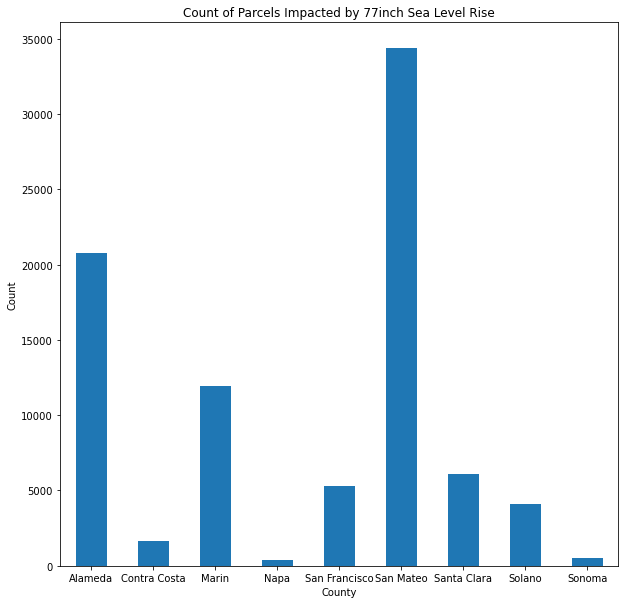

In [132]:
#Graph inundation parcels by county
bcdc_gp_cty = bcdc_parcels_centroid[bcdc_parcels_centroid['index_right'].notnull()].groupby(['county']).agg('size')

#plot
bcdc_gp_cty.plot(kind='bar',figsize=(10,10))

#title and labels
plt.title('Count of Parcels Impacted by 77inch Sea Level Rise')
plt.xlabel('County')
plt.ylabel('Count')

plt.xticks( 
    [0,1,2,3,4,5,6,7,8], # positions
    ['Alameda','Contra Costa','Marin','Napa','San Francisco','San Mateo','Santa Clara','Solano','Sonoma'], # labels
    rotation = 0 # default is 90
)

# convert to non-scientific notation 
plt.ticklabel_format(axis = 'y', style='plain');

In [134]:
#upsert to socrata
sub_columns = ['parcel_id','sea_level']
upsert_df_socrata(bcdc_parcels_centroid[sub_columns],
                 housing_site_db_id,
                 chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to d8wd-vg4y
took 10.5613 minutes


### Process Brownfield Sites <a name="brownfield"></a>

In [30]:
data_dir

'/Users/jcroff/Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data'

In [32]:
! ls '/Users/jcroff/Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/CalEnviroStore'

EnviroStorCleanupSites       EnviroStorHazardousWaste.zip
EnviroStorCleanupSites.zip   EnviroStorICESites
EnviroStorHazardousWaste     EnviroStorICESites.zip


In [47]:
brownfield_sites_df = pd.read_csv(os.path.join(data_dir,
                                            'CalEnviroStore',
                                           'EnviroStorCleanupSites',
                                           'sites.txt'),sep="\\t")

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [97]:
brownfield_sites_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12877 entries, 0 to 12876
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   PROJECT_NAME                  12877 non-null  object  
 1   ADDRESS                       12877 non-null  object  
 2   CITY                          12873 non-null  object  
 3   STATE                         12877 non-null  object  
 4   ZIP                           11927 non-null  object  
 5   COUNTY                        12874 non-null  object  
 6   SITE_TYPE                     12877 non-null  object  
 7   SITE_TYPE_DETAILED            12877 non-null  object  
 8   ACRES                         8761 non-null   object  
 9   APN                           12877 non-null  object  
 10  NATIONAL_PRIORITIES_LIST      12877 non-null  object  
 11  REGULATORY_AGENCIES_INVOLVED  12877 non-null  object  
 12  LEAD_AGENCY                   12877 non-null  

In [99]:
brownfield_sites_df['STATUS'].head(5)

0    Certified O&M - Land Use Restrictions Only
1                            No Action Required
2                    Inactive - Action Required
3                             No Further Action
4                            No Action Required
Name: STATUS, dtype: object

In [60]:
brownfield_sites = gp.GeoDataFrame(brownfield_sites_df, 
                                   geometry=gp.points_from_xy(brownfield_sites_df.LONGITUDE, 
                                                              brownfield_sites_df.LATITUDE),
                                  crs='EPSG:4326')

In [61]:
brownfield_sites.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12877 entries, 0 to 12876
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   PROJECT_NAME                  12877 non-null  object  
 1   ADDRESS                       12877 non-null  object  
 2   CITY                          12873 non-null  object  
 3   STATE                         12877 non-null  object  
 4   ZIP                           11927 non-null  object  
 5   COUNTY                        12874 non-null  object  
 6   SITE_TYPE                     12877 non-null  object  
 7   SITE_TYPE_DETAILED            12877 non-null  object  
 8   ACRES                         8761 non-null   object  
 9   APN                           12877 non-null  object  
 10  NATIONAL_PRIORITIES_LIST      12877 non-null  object  
 11  REGULATORY_AGENCIES_INVOLVED  12877 non-null  object  
 12  LEAD_AGENCY                   12877 no

In [62]:
#Get unique county values
brownfield_sites['COUNTY'].unique()

array(['SHASTA', 'LOS ANGELES', 'YOLO', 'TULARE', 'YUBA', 'IMPERIAL',
       'PLACER', 'SACRAMENTO', 'STANISLAUS', 'SAN BERNARDINO', 'KERN',
       'MONTEREY', 'SANTA CLARA', 'SISKIYOU', 'ALAMEDA', 'SAN DIEGO',
       'AMADOR', 'BUTTE', 'MARIN', 'SAN MATEO', 'NAPA', 'MERCED',
       'FRESNO', 'RIVERSIDE', 'MADERA', 'SANTA CRUZ', 'SOLANO', 'ORANGE',
       'NEVADA', 'VENTURA', 'SAN JOAQUIN', 'CONTRA COSTA',
       'SAN FRANCISCO', 'TEHAMA', 'SAN LUIS OBISPO', 'INYO',
       'SANTA BARBARA', 'MODOC', 'MONO', 'TRINITY', 'CALAVERAS', 'SONOMA',
       'SAN BENITO', 'DEL NORTE', 'HUMBOLDT', 'KINGS', 'PLUMAS', 'LASSEN',
       'MENDOCINO', 'COLUSA', 'LAKE', 'TUOLUMNE', 'SUTTER', 'MARIPOSA',
       'ALPINE', 'EL DORADO', nan, 'GLENN', 'SIERRA'], dtype=object)

In [69]:
#Subset Bay Area Counties
bay_counties = ['ALAMEDA',
                'MARIN',
                'SAN MATEO',
                'NAPA',
                'SOLANO',
                'CONTRA COSTA',
                'SAN FRANCISCO',
                'SONOMA']
brownfield_sites = brownfield_sites[brownfield_sites['COUNTY'].isin(bay_counties)]

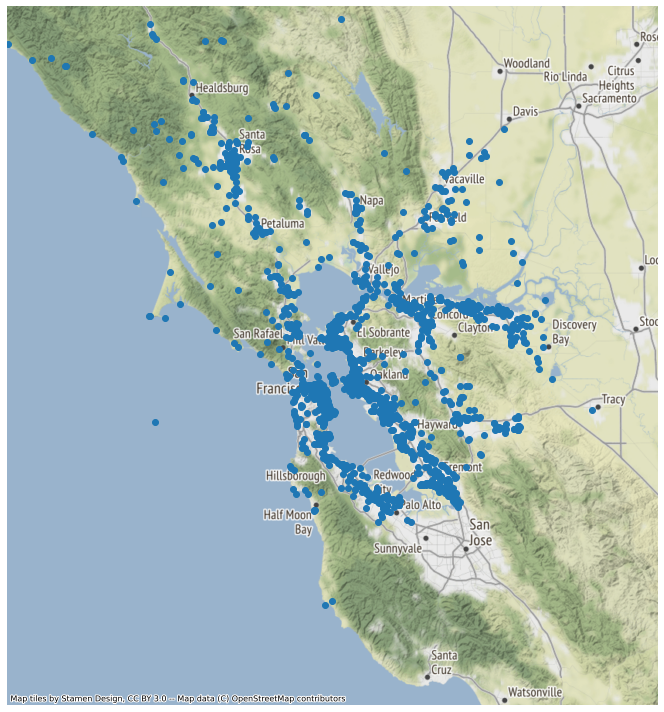

In [71]:
#Plot Bay County Brownfield Sites
ax = brownfield_sites.to_crs('EPSG:3857').plot(figsize=(10,10))

# Crop map to sf bounds
minx, miny, maxx, maxy = parcels.to_crs('epsg:3857').geometry.total_bounds
ax.set_xlim(minx,maxx)
ax.set_ylim(miny,maxy)

ax.set_axis_off()
ctx.add_basemap(ax)

#Display map
plt.tight_layout()
plt.show()

In [81]:
parcels_centroid.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [88]:
data_dir

'/Users/jcroff/Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data'

In [90]:
ls '/Users/jcroff/Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/CalEnviroStore'

EnviroStorCleanupSites/       EnviroStorHazardousWaste.zip
EnviroStorCleanupSites.zip    EnviroStorICESites/
EnviroStorHazardousWaste/     EnviroStorICESites.zip


In [118]:
parcels.geom_type.unique()

array(['MultiPolygon'], dtype=object)

In [83]:
#Join brownfields with parcel polygons for flagging
brownfield_parcels = gp.sjoin(parcels,
                              brownfield_sites,
                              how='inner',
                              op='intersects')

In [84]:
brownfield_parcels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 0 entries
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   PROJECT_NAME                  0 non-null      object  
 1   ADDRESS                       0 non-null      object  
 2   CITY                          0 non-null      object  
 3   STATE                         0 non-null      object  
 4   ZIP                           0 non-null      object  
 5   COUNTY                        0 non-null      object  
 6   SITE_TYPE                     0 non-null      object  
 7   SITE_TYPE_DETAILED            0 non-null      object  
 8   ACRES                         0 non-null      object  
 9   APN                           0 non-null      object  
 10  NATIONAL_PRIORITIES_LIST      0 non-null      object  
 11  REGULATORY_AGENCIES_INVOLVED  0 non-null      object  
 12  LEAD_AGENCY                   0 non-null      object  

In [79]:
brownfield_parcels[brownfield_parcels['index_right'].isnull()].shape

(2142677, 45)

In [80]:
brownfield_parcels.head(10)

,parcel_id,geom_id,county,city,apn,acres,tract_geoi,blkgp_geoi,centroid_x,centroid_y,...,STATUS_DATE,PAST_USES,POTENTIAL_COC,CONFIRMED_COC,POTENTIAL_MEDIA_AFFECTED,RESTRICTED_USE,SITE_MGMT_REQ,FUNDING,LATITUDE,LONGITUDE
0,CC216362001,7009279288522476710,13.0,Danville,216362001,0.292997041010582,06013346203,060133462031,-121.980750,37.817481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL412001710300,N6256491958109459820,1.0,Unincorporated Alameda,412001710300,0.11233469068488,06001435800,060014358004,-122.133371,37.682392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MA07310130,N6871088271220904570,41.0,Ross,07310130,0.164000229689994,06041118100,060411181002,-122.560350,37.967028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SM051152170,298947041927966577,81.0,Unincorporated San Mateo,051152170,0.323938867215386,06081609603,060816096033,-122.260126,37.480667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SN090030001000,N341579833062238894,97.0,Unincorporated Sonoma,090030001000,38.5110827514146,06097154000,060971540001,-122.958405,38.669488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,AL483004802300,1935949360512211430,1.0,Union City,483004802300,0.127550665861693,06001440334,060014403341,-122.067019,37.593173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,AL483004104100,N1520820874983714487,1.0,Union City,483004104100,0.134557506684507,06001440334,060014403341,-122.068171,37.596023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,AL483004509600,1130277565443232748,1.0,Union City,483004509600,0.123686658114064,06001440334,060014403342,-122.060856,37.592753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,AL483004801500,1818819557309733935,1.0,Union City,483004801500,0.126903630800446,06001440334,060014403341,-122.067369,37.593350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,AL483004904400,3195054693269816475,1.0,Union City,483004904400,0.124958122607138,06001440334,060014403341,-122.063144,37.589366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**[Back to Top](#top)**

## Step 7: Process Planning Datasets <a name="planning"></a>

#### Priority Development Areas

- Flag column (0: Outside PDA; 1: Inside PDA) 

#### Prior RHNA sites data

Following the adoption of the Regional Housing Need Assessment (RHNA), each jurisdiction is required to update its housing element to identify sites adequate to accommodate the number of units allocated to them. The parcel list was compiled from the housing opportunity sites inventories prepared by each of the Bay Area's 101 cities and nine counties as part of the 2007-2014 and 2015-2023 RHNA housing element cycles.

- RHNA 4 and RHNA 5 columns will be flagged (0: Not a previous RHNA site, 1: Was a previous RHNA site), depending on RHNA cycle. 

#### Zoning

Zoning data was compiled form zoning ordinances for every city and county in the Bay Area. This data includes the zoning code, description, overlay, and maxiumum allowable residential density as well as other information. 

- Columns from this dataset that will be associated with parcels include:
    - Zoning Code
    - Zoning Code Description
    - Zoning Overlay Description
    - Maximum Dwelling Units / Acre (Allowable Density) 

#### General Plan 

General plan data was compiled from some general plans but is incomplete. The data collected includes general plan code, description, and maxiumum allowable residential density. 

- Columns from this dataset that will be associated with parcels include: 
    - General Plan Code
    - General Plan Code Description
    - Maxium Dwelling Units / Acre (Allowable Density) 

#### Regional Property Characteristics 

Regional property chracteristics were collected from each of the 9-County Assessor's offices in the Bay Area. 

- Columns from this dataset that will be associated with parcels include: 
    - Existing Use Code
    - Existing Use Code Description 
    - Public Ownership 
    - Vacant Parcel 
    - Underutilized 

**[Back to Top](#top)**
### Process Priority Development Areas <a name="pda"></a>

In [139]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk']

In [140]:
pda = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                  driver='FileGDB',
                  layer='priority_development_areas_current')

In [141]:
pda.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [142]:
pda.head(5)

,join_key,county,jurisdicti,pda_name,acres,Shape__Area,Shape__Length,Shape_Length,Shape_Area,geometry
0,230ec884-82c6-4074-a3e2-877bb1cea97b,Alameda,Berkeley,North Berkeley BART,13,0.000005,0.009432,0.009432,0.000005,"MULTIPOLYGON (((-122.28492 37.87463, -122.2847..."
1,0a13cdcd-d2e8-46e1-8652-60d54f28c843,Alameda,Fremont,Irvington Transit Priority Development Area,803,0.000331,0.095005,0.095005,0.000331,"MULTIPOLYGON (((-121.96350 37.53871, -121.9603..."
2,a75db8bd-4a27-4288-b878-24cee994e148,Alameda,Fremont,Centerville Transit Priority Development Area,582,0.000240,0.064045,0.064045,0.000240,"MULTIPOLYGON (((-122.00152 37.56471, -122.0015..."
3,84b5bd67-82eb-4202-9a66-a978d2218197,Alameda,Fremont,Downtown/City CenterTransit Priority Developme...,920,0.000380,0.089982,0.089982,0.000380,"MULTIPOLYGON (((-121.97847 37.54683, -121.9786..."
4,f50e7d2c-0fce-4fb6-83bb-7c037aa9446a,Alameda,Fremont,Warm Springs Innovation District Transit Prior...,913,0.000376,0.091934,0.091934,0.000376,"MULTIPOLYGON (((-121.94186 37.51030, -121.9417..."


In [143]:
#Spatially join parcel centroids w/ pdas
pda_parcel_centroid = gp.sjoin(parcels_centroid,
                              pda,
                              how='left',
                              op='intersects')

In [144]:
pda_parcel_centroid.head(5)

,parcel_id,geom_id,county_left,city,apn,acres_left,tract_geoi,blkgp_geoi,centroid_x,centroid_y,...,index_right,join_key,county_right,jurisdicti,pda_name,acres_right,Shape__Area,Shape__Length,Shape_Length,Shape_Area
0,AL99A256000110,N5817775096018233128,1.0,Unincorporated Alameda,99A256000110,106.927944937336,06001451101,060014511013,-121.596790,37.581694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL525128205800,7316709377530651714,1.0,Fremont,525128205800,0.370856727459726,06001443002,060014430023,-121.957118,37.521598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL99A256000109,N527005802064910811,1.0,Unincorporated Alameda,99A256000109,101.938704741621,06001451101,060014511013,-121.603007,37.581767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL986001300100,3727940690343027220,1.0,Dublin,986001300100,1.27190710767633,06001450102,060014501023,-121.881581,37.709281,...,92.0,bec430c5-1512-4f41-92d8-0356caf9c22a,Alameda,Dublin,Town Center,676.0,0.00028,0.091905,0.091905,0.00028
4,AL99A293200300,2796948223684118431,1.0,Unincorporated Alameda,99A293200300,2.10466188922604,06001451501,060014515012,-121.729299,37.669970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
pda_parcel_centroid[pda_parcel_centroid['index_right'].notnull()].shape

(401581, 21)

In [146]:
pda_parcel_centroid['pda'] = np.where(pda_parcel_centroid['index_right'].notnull(),1,0)

In [147]:
pda_parcel_centroid[pda_parcel_centroid['pda'] == 1].head(5)

,parcel_id,geom_id,county_left,city,apn,acres_left,tract_geoi,blkgp_geoi,centroid_x,centroid_y,...,join_key,county_right,jurisdicti,pda_name,acres_right,Shape__Area,Shape__Length,Shape_Length,Shape_Area,pda
3,AL986001300100,3727940690343027220,1.0,Dublin,986001300100,1.27190710767633,06001450102,060014501023,-121.881581,37.709281,...,bec430c5-1512-4f41-92d8-0356caf9c22a,Alameda,Dublin,Town Center,676.0,0.000280,0.091905,0.091905,0.000280,1
7,AL543042806300,N4262495264119460416,1.0,Fremont,543042806300,1.52529970991809,06001441401,060014414014,-122.033590,37.570074,...,695db3f4-bd3b-4716-9a9b-8c1e9d6e2e2a,Alameda,Fremont,North Fremont Boulevard Connected Community Pr...,732.0,0.000302,0.118105,0.118105,0.000302,1
18,SF3514197,507393735700634042,75.0,San Francisco,3514197,0.989925861588401,06075020100,060750201001,-122.418802,37.771564,...,d397f42d-18fb-4e1b-9f97-3fb6597e9208,San Francisco,San Francisco,Market Octavia,536.0,0.000222,0.100755,0.100755,0.000222,1
20,SF3514049,507393735700634042,75.0,San Francisco,3514049,0.989925861588401,06075020100,060750201001,-122.418802,37.771564,...,d397f42d-18fb-4e1b-9f97-3fb6597e9208,San Francisco,San Francisco,Market Octavia,536.0,0.000222,0.100755,0.100755,0.000222,1
21,SF3514102,507393735700634042,75.0,San Francisco,3514102,0.989925861588401,06075020100,060750201001,-122.418802,37.771564,...,d397f42d-18fb-4e1b-9f97-3fb6597e9208,San Francisco,San Francisco,Market Octavia,536.0,0.000222,0.100755,0.100755,0.000222,1


In [148]:
#Upsert to socrata
upsert_df_socrata(pda_parcel_centroid[['parcel_id','pda']],
                  housing_site_db_id,
                  chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to d8wd-vg4y
took 9.3987 minutes


**[Back to Top](#top)**
### Process Prior RHNA Sites <a name="rhna"></a>

In [20]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk',
 'california_protected_areas_database',
 'regional_housing_need_assessment_sites',
 'art_slr_inundation_poly_77',
 'art_slr_lowlying_poly_77']

In [23]:
#Read RHNA dataset from FileGDB
rhna_sites = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                  driver='FileGDB',
                  layer='regional_housing_need_assessment_sites')

In [24]:
rhna_sites.head(5)

,rhnacyc,rhnayrs,county,jurisdict,apn,locapn,genplan,zoning,gacres,locacres,...,infcapcty,siteconst,sitetype,pdaparcel,bundled,existuse,localnote,shape_Length,shape_Area,geometry
0,RHNA4,2007-2014,6001,Berkeley,055-1825-020-00,055 182502000,AC,C-SA,0.234,0.23,...,None,None,Underutilized,Y,None,Berkeley Honda Car Lot,None,0.001269,9.683965e-08,"MULTIPOLYGON (((-122.26618 37.86184, -122.2664..."
1,RHNA4,2007-2014,6001,Berkeley,057-2059-012-00,057 205901200,DT,C-1,0.099,0.11,...,None,None,Underutilized,Y,None,Flamingo's Cleaners,None,0.001028,4.085816e-08,"MULTIPOLYGON (((-122.27251 37.87207, -122.2726..."
2,RHNA4,2007-2014,6001,Berkeley,055-1829-011-00,055 182901100,MDR,R-2A,0.154,0.15,...,None,None,Vacant,None,None,VACANT,None,0.001089,6.365583e-08,"MULTIPOLYGON (((-122.26420 37.86264, -122.2643..."
3,RHNA4,2007-2014,6001,Berkeley,057-2046-001-00,057 204600100,DT,C-1,0.398,0.40,...,None,None,Underutilized,Y,None,"Missing Link Bicycle Coop, Berkeley Vacuum Center",None,0.001633,1.648733e-07,"MULTIPOLYGON (((-122.26784 37.87269, -122.2680..."
4,RHNA4,2007-2014,6001,Berkeley,057-2053-008-01,057 205300801,DT,C-1,0.266,0.28,...,None,None,Underutilized,Y,None,Lhasa Hair Salon,None,0.001333,1.102806e-07,"MULTIPOLYGON (((-122.26964 37.87213, -122.2700..."


In [25]:
rhna_sites.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 42133 entries, 0 to 42132
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   rhnacyc       42133 non-null  object  
 1   rhnayrs       42133 non-null  object  
 2   county        42133 non-null  object  
 3   jurisdict     42133 non-null  object  
 4   apn           42105 non-null  object  
 5   locapn        42128 non-null  object  
 6   genplan       37177 non-null  object  
 7   zoning        33509 non-null  object  
 8   gacres        42133 non-null  float64 
 9   locacres      42133 non-null  float64 
 10  currunits     42133 non-null  int64   
 11  allowden      23912 non-null  object  
 12  allowlow      42133 non-null  int64   
 13  allowhigh     42133 non-null  int64   
 14  relcapcty     31466 non-null  object  
 15  desafford     6044 non-null   object  
 16  aff_vl        1163 non-null   object  
 17  aff_l         1591 non-null   object  
 18

In [26]:
rhna_sites.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
#Spatially join parcel centroids with rhna dataset
rhna_parcels_centroid = gp.sjoin(parcels_centroid,
                                rhna_sites,
                                how='left',
                                op='intersects')

In [28]:
rhna_parcels_centroid.head(5)

,parcel_id,geom_id,county_left,city,apn_left,acres,tract_geoi,blkgp_geoi,centroid_x,centroid_y,...,num_am,infcapcty,siteconst,sitetype,pdaparcel,bundled,existuse,localnote,shape_Length,shape_Area
0,CC179131016,N812175068441799346,13.0,Walnut Creek,179131016,0.571898281089132,06013343002,060133430021,-122.047866,37.905228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CC216362001,7009279288522476710,13.0,Danville,216362001,0.292997041010582,06013346203,060133462031,-121.980750,37.817481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CC093490066,N4056657309732995167,13.0,Pittsburg,093490066,0.0674453215949994,06013355200,060133552002,-121.953865,38.016272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL412001710300,N6256491958109459820,1.0,Unincorporated Alameda,412001710300,0.11233469068488,06001435800,060014358004,-122.133371,37.682392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MA07310130,N6871088271220904570,41.0,Ross,07310130,0.164000229689994,06041118100,060411181002,-122.560350,37.967028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
rhna_parcels_centroid.groupby(['rhnacyc']).agg('size')

rhnacyc
RHNA4    49902
RHNA5    42843
dtype: int64

In [36]:
rhna_parcels_centroid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2179929 entries, 0 to 2142676
Data columns (total 47 columns):
 #   Column        Dtype   
---  ------        -----   
 0   parcel_id     object  
 1   geom_id       object  
 2   county_left   object  
 3   city          object  
 4   apn_left      object  
 5   acres         object  
 6   tract_geoi    object  
 7   blkgp_geoi    object  
 8   centroid_x    float64 
 9   centroid_y    float64 
 10  geometry      geometry
 11  index_right   float64 
 12  rhnacyc       object  
 13  rhnayrs       object  
 14  county_right  object  
 15  jurisdict     object  
 16  apn_right     object  
 17  locapn        object  
 18  genplan       object  
 19  zoning        object  
 20  gacres        float64 
 21  locacres      float64 
 22  currunits     float64 
 23  allowden      object  
 24  allowlow      float64 
 25  allowhigh     float64 
 26  relcapcty     object  
 27  desafford     object  
 28  aff_vl        object  
 29  aff_l 

In [37]:
parcels_centroid.shape

(2142677, 11)

In [38]:
#create new flag columns
rhna_parcels_centroid['rhna_4'] = np.where((rhna_parcels_centroid['rhnacyc'] == 'RHNA4'), 1,0)

In [39]:
rhna_parcels_centroid['rhna_5'] = np.where((rhna_parcels_centroid['rhnacyc'] == 'RHNA5'), 1,0)

In [40]:
rhna_parcels_centroid[['parcel_id','rhnacyc','rhna_4','rhna_5']][rhna_parcels_centroid['rhnacyc'].notnull()]

,parcel_id,rhnacyc,rhna_4,rhna_5
66,SN002091023000,RHNA5,0,1
66,SN002091023000,RHNA4,1,0
161,SC30353018,RHNA4,1,0
218,SM007311160,RHNA5,0,1
218,SM007311160,RHNA4,1,0
...,...,...,...,...
2142420,AL097000102200,RHNA4,1,0
2142420,AL097000102200,RHNA5,0,1
2142424,CC206750013,RHNA4,1,0
2142619,SC20944002,RHNA4,1,0


In [41]:
parcels_centroid.shape

(2142677, 11)

In [42]:
rhna_parcels_centroid.shape

(2179929, 47)

In [43]:
rhna_parcels_centroid[rhna_parcels_centroid.duplicated(subset=['parcel_id'])].shape

(37252, 47)

In [44]:
#De-duplicate
rhna_parcels_centroid_dedup = rhna_parcels_centroid.drop_duplicates(subset=['parcel_id'])

In [45]:
rhna_parcels_centroid_dedup.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2142677 entries, 0 to 2142676
Data columns (total 47 columns):
 #   Column        Dtype   
---  ------        -----   
 0   parcel_id     object  
 1   geom_id       object  
 2   county_left   object  
 3   city          object  
 4   apn_left      object  
 5   acres         object  
 6   tract_geoi    object  
 7   blkgp_geoi    object  
 8   centroid_x    float64 
 9   centroid_y    float64 
 10  geometry      geometry
 11  index_right   float64 
 12  rhnacyc       object  
 13  rhnayrs       object  
 14  county_right  object  
 15  jurisdict     object  
 16  apn_right     object  
 17  locapn        object  
 18  genplan       object  
 19  zoning        object  
 20  gacres        float64 
 21  locacres      float64 
 22  currunits     float64 
 23  allowden      object  
 24  allowlow      float64 
 25  allowhigh     float64 
 26  relcapcty     object  
 27  desafford     object  
 28  aff_vl        object  
 29  aff_l 

In [46]:
rhna_parcels_centroid_dedup.head(5)

,parcel_id,geom_id,county_left,city,apn_left,acres,tract_geoi,blkgp_geoi,centroid_x,centroid_y,...,siteconst,sitetype,pdaparcel,bundled,existuse,localnote,shape_Length,shape_Area,rhna_4,rhna_5
0,CC179131016,N812175068441799346,13.0,Walnut Creek,179131016,0.571898281089132,06013343002,060133430021,-122.047866,37.905228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,CC216362001,7009279288522476710,13.0,Danville,216362001,0.292997041010582,06013346203,060133462031,-121.980750,37.817481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,CC093490066,N4056657309732995167,13.0,Pittsburg,093490066,0.0674453215949994,06013355200,060133552002,-121.953865,38.016272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,AL412001710300,N6256491958109459820,1.0,Unincorporated Alameda,412001710300,0.11233469068488,06001435800,060014358004,-122.133371,37.682392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,MA07310130,N6871088271220904570,41.0,Ross,07310130,0.164000229689994,06041118100,060411181002,-122.560350,37.967028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [47]:
#Upsert to socrata
upsert_df_socrata(rhna_parcels_centroid_dedup[['parcel_id','rhna_4','rhna_5']],
                  housing_site_db_id,
                  chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to d8wd-vg4y
took 10.3647 minutes


**[Back to Top](#top)**
### Process Zoning <a name="zoning"></a>

In [149]:
# Read in zoning and general plan bridge table
gp_zoning_bridge = pull_df_from_socrata('c2b7-6c8p')

pulling data in 9 chunks of 250000 rows each
pulling chunk 0
pulling chunk 1
pulling chunk 2
pulling chunk 3
pulling chunk 4
pulling chunk 5
pulling chunk 6
pulling chunk 7
pulling chunk 8
took 21.5877 seconds


In [150]:
gp_zoning_bridge.head(5)

,geom_id,recid,editor,edit_date
0,N7048726851848113656,6c459d2c-daf3-4cac-b20c-8472c10dd792,NaN,NaN
1,N2250681206250696451,025e717f-900c-4011-8503-7b102c7a0933,NaN,NaN
2,N7483598866155113920,437e90f2-8cac-4057-b658-678848f7c019,NaN,03-09-2020
3,N8908818910097817915,dc323e46-2ca5-4c65-aaea-bd13d8420b3d,NaN,NaN
4,N1486116264581352684,5a6d3363-b377-4431-8ac8-35aa1593225d,NaN,12-19-2019


In [151]:
gp_zoning_bridge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044386 entries, 0 to 2044385
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   geom_id    object
 1   recid      object
 2   editor     object
 3   edit_date  object
dtypes: object(4)
memory usage: 62.4+ MB


In [152]:
# Pull in zoning data from socrata 
zoning = pull_df_from_socrata('r3pf-wkks')
zoning.head(5)

pulling data in 1 chunks of 5197 rows each
pulling chunk 0
took 3.1665 seconds


,recid,county_name,city_name,zn_code,zn_description,zn_area_overlay,regional_lu_class,max_far,max_dua,building_height,minimum_lot_sqft,lot_coverage,units_per_lot,editor,edit_date,zn_code_color,source
0,0182e52b-75aa-4e05-9196-6b4deb7d9bdd,Alameda,Alameda,R-1,One-Family Residence District,NaN,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-08-28T00:00:00,#FFFFFF,NaN
1,a42579cd-ae0c-477c-b981-5455d20698cd,Alameda,Alameda,R-1-A-H-30,One-Family Residence District,NaN,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-04-29T00:00:00,#FFFFFF,NaN
2,e20a4df9-7417-4764-bd26-99e19916ebba,Alameda,Alameda,R-1-A-H-40,One-Family Residence District,NaN,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-04-29T00:00:00,#FFFFFF,NaN
3,c0a4fb19-8f44-49de-91e4-c983c4fe2df8,Alameda,Alameda,R-1-A-PD,One-Family Residence District,Planned Development District,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-04-29T00:00:00,#FFFFFF,NaN
4,7cb57357-2110-4ff8-ac79-ee04ec3c4612,Alameda,Alameda,R-1-A-PD,One-Family Residence District,Planned Development District,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-04-29T00:00:00,#FFFE55,NaN


In [153]:
zoning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recid              5197 non-null   object 
 1   county_name        5160 non-null   object 
 2   city_name          5197 non-null   object 
 3   zn_code            5196 non-null   object 
 4   zn_description     5052 non-null   object 
 5   zn_area_overlay    1098 non-null   object 
 6   regional_lu_class  5188 non-null   float64
 7   max_far            4944 non-null   float64
 8   max_dua            4456 non-null   float64
 9   building_height    3077 non-null   float64
 10  minimum_lot_sqft   1373 non-null   float64
 11  lot_coverage       112 non-null    float64
 12  units_per_lot      812 non-null    float64
 13  editor             5197 non-null   object 
 14  edit_date          5197 non-null   object 
 15  zn_code_color      5197 non-null   object 
 16  source             595 n

In [154]:
# Merge gp and zoning bridge table w/ zoning table
zoning_and_bridge = pd.merge(gp_zoning_bridge[['geom_id','recid']],
                            zoning[['recid','zn_code','zn_description','zn_area_overlay','max_dua']],
                            on='recid',
                            how='inner')

In [155]:
zoning_and_bridge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2022311 entries, 0 to 2022310
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   geom_id          object 
 1   recid            object 
 2   zn_code          object 
 3   zn_description   object 
 4   zn_area_overlay  object 
 5   max_dua          float64
dtypes: float64(1), object(5)
memory usage: 108.0+ MB


In [156]:
#Rename max_far column to match site selection schema
zoning_and_bridge.rename(columns={'max_dua':'zn_max_dua'},
                         inplace=True)

In [157]:
zoning_and_bridge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2022311 entries, 0 to 2022310
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   geom_id          object 
 1   recid            object 
 2   zn_code          object 
 3   zn_description   object 
 4   zn_area_overlay  object 
 5   zn_max_dua       float64
dtypes: float64(1), object(5)
memory usage: 108.0+ MB


In [158]:
zoning_and_bridge.head(10)

,geom_id,recid,zn_code,zn_description,zn_area_overlay,zn_max_dua
0,N7048726851848113656,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
1,4974405566792209754,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
2,1287593219279599460,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
3,7767969963689623036,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
4,N5605796467262203641,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
5,3162063837881530328,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
6,3437294762313958568,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
7,N3149764479670251269,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
8,N956514525116259204,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
9,N1053274242604597070,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN


In [159]:
parcels.head(5)

,parcel_id,geom_id,county,city,apn,acres,tract_geoi,blkgp_geoi,centroid_x,centroid_y,geometry
0,AL99A256000110,N5817775096018233128,1.0,Unincorporated Alameda,99A256000110,106.927944937336,06001451101,060014511013,-121.596790,37.581694,POINT (-121.59679 37.58169)
1,AL525128205800,7316709377530651714,1.0,Fremont,525128205800,0.370856727459726,06001443002,060014430023,-121.957118,37.521598,POINT (-121.95712 37.52160)
2,AL99A256000109,N527005802064910811,1.0,Unincorporated Alameda,99A256000109,101.938704741621,06001451101,060014511013,-121.603007,37.581767,POINT (-121.60301 37.58177)
3,AL986001300100,3727940690343027220,1.0,Dublin,986001300100,1.27190710767633,06001450102,060014501023,-121.881581,37.709281,POINT (-121.88158 37.70928)
4,AL99A293200300,2796948223684118431,1.0,Unincorporated Alameda,99A293200300,2.10466188922604,06001451501,060014515012,-121.729299,37.669970,POINT (-121.72930 37.66997)


In [160]:
#join to parcels 
zoning_and_bridge_parcels = pd.merge(parcels[['parcel_id','geom_id']],
                                    zoning_and_bridge,
                                    on='geom_id',
                                    how='left')

In [161]:
zoning_and_bridge_parcels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2142677 entries, 0 to 2142676
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   parcel_id        object 
 1   geom_id          object 
 2   recid            object 
 3   zn_code          object 
 4   zn_description   object 
 5   zn_area_overlay  object 
 6   zn_max_dua       float64
dtypes: float64(1), object(6)
memory usage: 130.8+ MB


In [164]:
zoning_and_bridge_parcels[zoning_and_bridge_parcels['recid'].notnull()].shape

(2120123, 7)

In [165]:
parcels.shape

(2142677, 11)

In [173]:
zoning_and_bridge_parcels.tail(10) 

,parcel_id,geom_id,recid,zn_code,zn_description,zn_area_overlay,zn_max_dua
2142667,SC45112003,N7517414755873877932,76a7045e-3bc8-52ad-b916-05faca161525,RN,Residential Neighborhood,NaN,9.00
2142668,SC36924001,5636016236614434771,8095f01a-931c-4abe-9aaa-40b93cee36c1,R1,Single-Family Residential,NaN,5.00
2142669,SN015481024000,3697898646719648773,49d375fe-83d2-11e9-9a4b-526af7764f64,PD,Planned Development,NaN,0.00
2142670,SL0170291260,4325586518646772826,34420b8d-73da-4df5-8b7d-271bb8b2febf,RLM:5,Low-Medium Density Residential 5,NaN,6.00
2142671,SN137130049000,N2438016649968574710,96d27dc8-6879-43c7-95c0-e74bbe2a6a34,PUD,Planned Unit District,NaN,0.00
2142672,SN144550024000,1099801990984160551,dce0dff9-9b10-4b3a-9f89-19ac16a285ae,NL,Neighborhood| Low Density,NaN,6.00
2142673,SN100254006000,1243665130075622340,701e8fa4-817c-4369-8cac-c26f5585b614,PC,Planned Community,NaN,0.00
2142674,SN082061072000,8195258132771493153,1f02edc5-c570-4396-985e-ac324839ae69,RR,Rural Residential,NaN,1.00
2142675,SL0130141180,475324628202377767,2bcb06c3-9e1e-4365-8cd1-2b15c9a33d8c,RL-6,Residential Low Density (6-000 sq. ft.),NaN,5.00
2142676,SN049482002000,1968967418036442245,49d2dc20-83d2-11e9-9a4b-526af7764f64,R-1-6,Single-Family Residential,NaN,7.26


In [167]:
#Upsert zoning data to socrata
upsert_df_socrata(zoning_and_bridge_parcels[['parcel_id','zn_code','zn_description','zn_area_overlay','zn_max_dua']],
                  housing_site_db_id,
                  chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to d8wd-vg4y
took 10.1182 minutes


**[Back to Top](#top)**
### Process General Plan <a name="generalplan"></a>